In [5]:
from astropy.io import fits
import aplpy
import numpy as np
import mpmath
from mpmath.libmp import from_float
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition, mark_inset)
from astropy.wcs import WCS
from astropy.visualization import wcsaxes
import collections.abc
collections.Iterable = collections.abc.Iterable
from astrodendro import Dendrogram
from astrodendro.analysis import PPStatistic
import pandas as pd
from scipy.optimize import curve_fit

In [6]:
def del_header_key(header, keys):
    import copy
    h = copy.deepcopy(header)
    for k in keys:
        try:
            del h[k]
        except:
            pass
    return h

def make_new_hdu_integ(hdu):
    data = hdu.data
    header = hdu.header
    new_data = np.nansum(data, axis=0)*header["CDELT3"]/1000.0
    header = del_header_key(header, ["CRVAL3", "CRPIX3", "CRVAL3", "CDELT3", "CUNIT3", "CTYPE3", "CROTA3", "NAXIS3"])
    header["NAXIS"] = 2
    new_hdu = fits.PrimaryHDU(new_data, header)
    return new_hdu

def make_new_hdu_mean(hdu):
    data = hdu.data
    header = hdu.header
    new_data = np.nanmean(data, axis=0)
    header = del_header_key(header, ["CRVAL3", "CRPIX3", "CRVAL3", "CDELT3", "CUNIT3", "CTYPE3", "CROTA3", "NAXIS3"])
    header["NAXIS"] = 2
    new_hdu = fits.PrimaryHDU(new_data, header)
    return new_hdu

def integ_concatenate(hdu1, hdu2):
    data1, header1 = hdu1.data, hdu1.header
    data2, header2 = hdu2.data, hdu2.header
    new_data = np.concatenate([data1, data2], axis=2)
    integ_data = np.nansum(new_data, axis=0)*header1["CDELT3"]/1000.0
    '''
    new_data1 = np.nansum(data1, axis=0)*header1["CDELT3"]/1000.0
    new_data2 = np.nansum(data2, axis=0)*header2["CDELT3"]/1000.0
    new_data = np.concatenate([new_data1, new_data2], axis=1)
    '''
    header = del_header_key(header1, ["CRVAL3", "CRPIX3", "CRVAL3", "CDELT3", "CUNIT3", "CTYPE3", "CROTA3", "NAXIS3"])
    header["NAXIS"] = 2
    new_hdu = fits.PrimaryHDU(new_data, header1)
    integ_hdu = fits.PrimaryHDU(integ_data, header)
    return new_hdu, integ_hdu

def mean_concatenate(hdu1, hdu2):
    data1, header1 = hdu1.data, hdu1.header
    data2, header2 = hdu2.data, hdu2.header
    new_data = np.concatenate([data1, data2], axis=2)
    integ_data = np.nanmean(new_data, axis=0)*header1["CDELT3"]/1000.0
    '''
    new_data1 = np.nanmean(data1, axis=0)*header1["CDELT3"]/1000.0
    new_data2 = np.nanmean(data2, axis=0)*header2["CDELT3"]/1000.0
    new_data = np.concatenate([new_data1, new_data2], axis=1)
    '''
    header = del_header_key(header1, ["CRVAL3", "CRPIX3", "CRVAL3", "CDELT3", "CUNIT3", "CTYPE3", "CROTA3", "NAXIS3"])
    header["NAXIS"] = 2
    new_hdu = fits.PrimaryHDU(new_data, header1)
    integ_hdu = fits.PrimaryHDU(integ_data, header)
    return new_hdu, integ_hdu

def xyv2ch(x, y, v, w):#km/s
    x_ch, y_ch, v_ch   = w.wcs_world2pix(x, y, v*1000.0, 0)
    x_ch = int(round(float(x_ch), 0))
    y_ch = int(round(float(y_ch), 0))
    v_ch = int(round(float(v_ch), 0))
    return x_ch, y_ch, v_ch
def xy2ch(x, y, w):
    x_ch, y_ch   = w.wcs_world2pix(x, y, 0)
    x_ch = int(round(float(x_ch), 0))
    y_ch = int(round(float(y_ch), 0))
    return x_ch, y_ch

def xy_cut(hdu, x_start, x_end, y_start, y_end):
    h = hdu.header
    d = hdu.data
    w = WCS(h)
    if d.ndim==3:
        x_start_ch, y_start_ch, v_tempo = xyv2ch(x_start, y_start, 0.0, w)
        x_end_ch, y_end_ch, v_tempo = xyv2ch(x_end, y_end, 0.0, w)  
        if x_start_ch<0 or y_start_ch<0 or x_end_ch>h["NAXIS1"]-2 or y_end_ch>h["NAXIS2"]-2:
            print("x_start_ch, x_end_ch = ", x_start_ch, x_end_ch)
            print("y_start_ch, y_end_ch = ", y_start_ch, y_end_ch)
            print("out of fits.")
            return
        d = d[:, y_start_ch:y_end_ch+1, x_start_ch:x_end_ch+1]
    elif d.ndim==2:
        x_start_ch, y_start_ch = xy2ch(x_start, y_start, w)
        x_end_ch, y_end_ch = xy2ch(x_end, y_end, w) 
        if x_start_ch<0 or y_start_ch<0 or x_end_ch>h["NAXIS1"]-2 or y_end_ch>h["NAXIS2"]-2:
            print("x_start_ch, x_end_ch = ", x_start_ch, x_end_ch)
            print("y_start_ch, y_end_ch = ", y_start_ch, y_end_ch)
            print("out of fits.")
            return
        d = d[y_start_ch:y_end_ch+1, x_start_ch:x_end_ch+1]
    else:
        print("data.ndim must be 2 or 3. ")
        return
    h['CRPIX1'] = h['CRPIX1'] - x_start_ch
    h['CRPIX2'] = h['CRPIX2'] - y_start_ch
    new_hdu = fits.PrimaryHDU(d, h)
    return new_hdu
def v_cut(hdu, v_start, v_end):
    h = hdu.header
    d = hdu.data
    w = WCS(h)
    x_tempo, y_tempo, v_tempo = w.wcs_pix2world(0, 0, 0, 0)
    x_tempo_ch, y_tempo_ch, v_start_ch = xyv2ch(x_tempo, y_tempo, v_start, w)
    x_tempo_ch, y_tempo_ch, v_end_ch = xyv2ch(x_tempo, y_tempo, v_end, w)
    if v_start_ch<0 or v_end_ch>h["NAXIS3"]-2:
            print("v_start_ch, v_end_ch = ", v_start_ch, v_end_ch)
            print("out of fits.")
            return
    d = d[v_start_ch:v_end_ch+1, :, :]
    h['CRPIX3'] = h['CRPIX3'] - v_start_ch
    new_hdu = fits.PrimaryHDU(d, h)
    return new_hdu

In [7]:
pix = 6000 * np.tan((2 * np.pi / 180) / 848) #pc

def calc_mass_12CO(flux):
    mass = flux * 2.0e20 * (pix * 3.0857e18) ** 2 * 1.6735575e-27 * 2.8 / 1.989e30 
    # mass [solar mass] = H2柱密度 [cm^-2] * size (1 pix) [cm^2] * 水素原子質量 [kg] * 2.8 / 太陽質量 [kg]
    return mass

def calc_mass_13CO(integ_hdu_12CO, mean_hdu_13CO, mask):
    integ_map_12CO = integ_hdu_12CO.data
    mean_data_13CO = np.nan_to_num(mean_hdu_13CO.data)
    #T_ex_13CO = 5.53 / np.log(1 + 5.53 / (np.max(integ_map_12CO[mask]) + 0.819))
    T_ex_13CO = 5.53 / np.log(1 + 5.53 / (np.nanmean(integ_map_12CO[mask]) + 0.819))
    #T_ex_13CO = 5.53 / np.log(1 + 5.53 / (20 + 0.819))
    J_13CO = 1 / (np.exp(5.29 / T_ex_13CO) - 1)
    tau = -np.log(1 - mean_data_13CO[mask] / (5.29 * (J_13CO - 0.164)))
    N_13 = 2.42e14 * T_ex_13CO / (1 - np.exp(-5.29 / T_ex_13CO)) * (tau * 0.65 * 462)
    N_H2 = 5e5 * N_13
    N_H2 = mpmath.mpf(from_float(np.sum(N_H2)))
    distance_factor = pix * mpmath.mpf('3.0857e18')
    distance_squared = distance_factor ** 2
    mass_factor = mpmath.mpf('1.6735575e-27')
    constant = mpmath.mpf('2.8')
    solar_mass = mpmath.mpf('1.989e30')
    part1 = N_H2 * distance_squared
    part2 = part1 * mass_factor
    part3 = part2 * constant
    mass = np.sum(part3 / solar_mass)
    #mass = np.sum(N_H2 * ((200/848) * 3.0857e18) ** 2 * 1.6735575e-27 * 2.8 / 1.989e30)
    return mass

def gaussian(x, height, center, width):
    return height * np.exp(-(x - center)**2 / (2 * width**2))
def fit_gaussian(x, y):
    initial_height = max(y)
    initial_center = x[np.argmax(y)]
    initial_width = 1
    initial_params = [initial_height, initial_center, initial_width]
    popt, pcov = curve_fit(gaussian, x, y, p0=initial_params)
    return popt
def calculate_fwhm(width):
    return 2 * np.sqrt(2 * np.log(2)) * width
def analyze_spectra(coordinates_list, data):
    spectra_list = []
    for i, j in coordinates_list:
        spectra_list.append(data[:, i, j])
    spe = np.sum(spectra_list, axis=0)
    x_spe = np.arange(len(spe))
    params = fit_gaussian(x_spe, spe)
    fwhm = calculate_fwhm(params[2])
    return fwhm

<>:115: SyntaxWarning: invalid escape sequence '\o'
<>:157: SyntaxWarning: invalid escape sequence '\o'
<>:115: SyntaxWarning: invalid escape sequence '\o'
<>:157: SyntaxWarning: invalid escape sequence '\o'
C:\Users\kotor\AppData\Local\Temp\ipykernel_12700\3476618724.py:115: SyntaxWarning: invalid escape sequence '\o'
  ax.set_xlabel('mass [$M_\odot$]')
C:\Users\kotor\AppData\Local\Temp\ipykernel_12700\3476618724.py:157: SyntaxWarning: invalid escape sequence '\o'
  ax.set_ylabel('mass [$M_\odot$]')


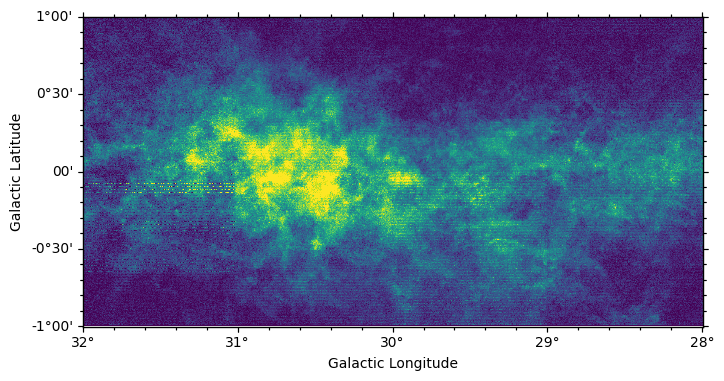

Total mass:  54376744.49757608 solar mass


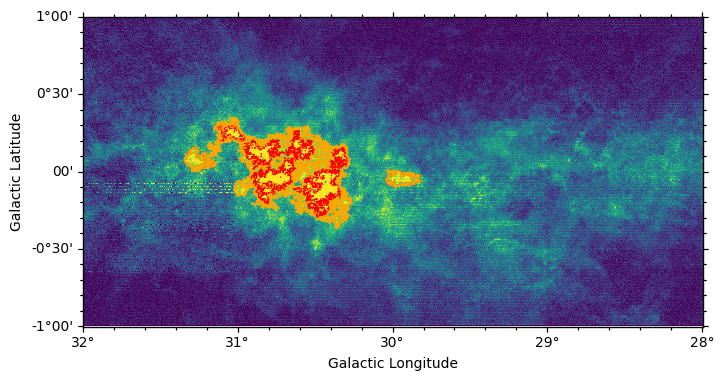

C:\Users\kotor\AppData\Local\Temp\ipykernel_12700\3476618724.py:100: MatplotlibDeprecationWarning: The InsetPosition class was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use Axes.inset_axes instead.
  position = InsetPosition(ax, [0.25, 0.35, 0.7, 0.6])
C:\Users\kotor\AppData\Local\Temp\ipykernel_12700\3476618724.py:106: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\kotor\AppData\Local\Temp\ipykernel_12700\3476618724.py:118: MatplotlibDeprecationWarning: The InsetPosition class was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use Axes.inset_axes instead.
  position = InsetPosition(ax, [0.25, 0.35, 0.7, 0.6])
C:\Users\kotor\AppData\Local\Temp\ipykernel_12700\3476618724.py:124: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\kotor\AppData\Local\Temp\ipykernel_12700\3476618724.py:136: MatplotlibDeprecationWarning: The InsetPosition

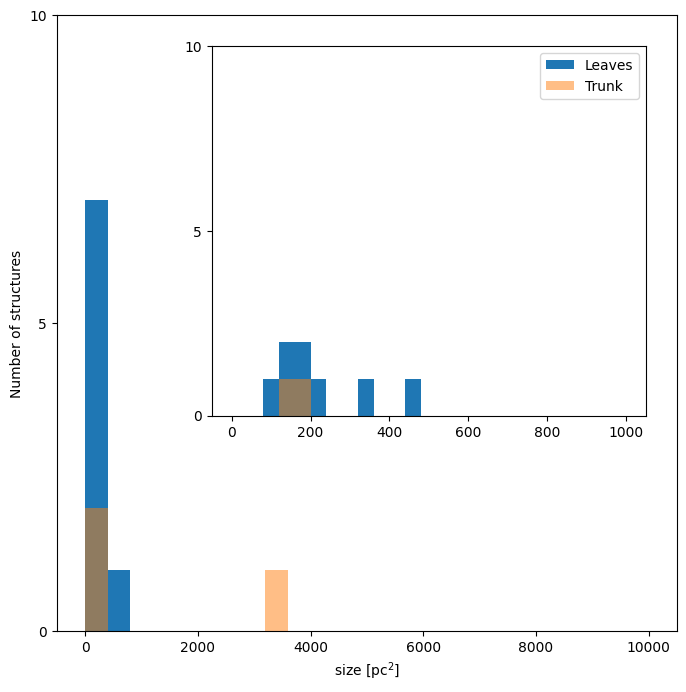

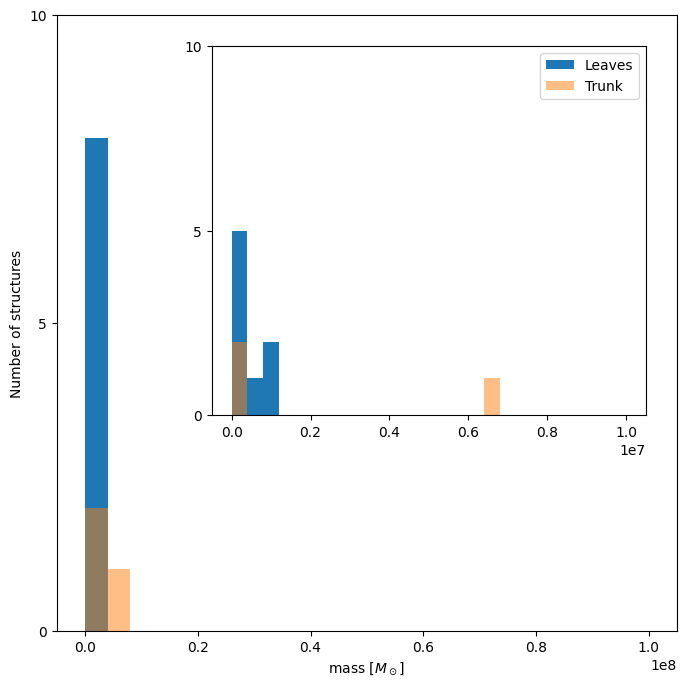

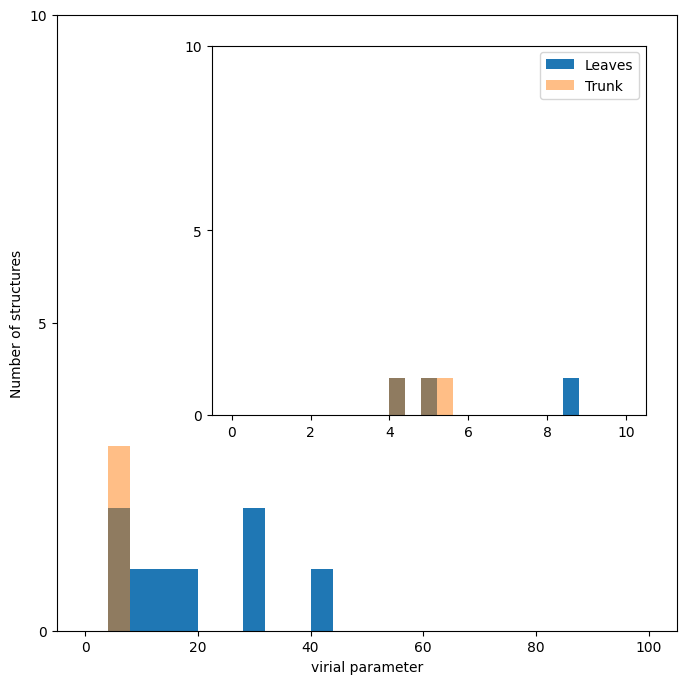

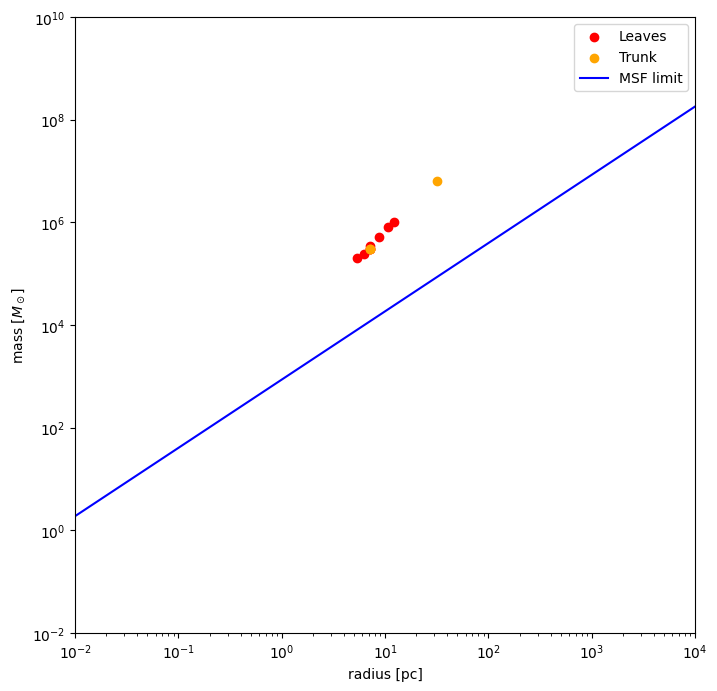

In [8]:
# 12CO

hdu_12CO_1 = fits.open("D:/obsdata/FGN_03100+0000_2x2_12CO_v1.00_cube.fits")[0] # 3D
hdu_12CO_2 = fits.open("D:/obsdata/FGN_02900+0000_2x2_12CO_v1.00_cube.fits")[0] # 3D
w1 = WCS(hdu_12CO_1.header, naxis=2)
w2 = WCS(hdu_12CO_2.header, naxis=2)
new_hdu_12CO, integ_hdu_12CO = integ_concatenate(hdu_12CO_1, hdu_12CO_2)
fig = plt.figure(figsize=(8, 8))
f = aplpy.FITSFigure(integ_hdu_12CO, slices=[0], convention='wells', figure=fig)
f.show_colorscale(vmin=1, vmax=500, cmap="viridis", aspect="equal")
plt.show()

total_mass_12CO = calc_mass_12CO(np.sum(integ_hdu_12CO.data))
print("Total mass: ", total_mass_12CO, "solar mass")

dendro_min_value = 2 * np.std(integ_hdu_12CO.data)
dendro_min_delta = np.std(integ_hdu_12CO.data)
dendro_min_npix = 1000
d = Dendrogram.compute(integ_hdu_12CO.data, min_value=dendro_min_value, min_delta=dendro_min_delta, min_npix=dendro_min_npix, verbose=False)

fig = plt.figure(figsize=(8, 8))
f = aplpy.FITSFigure(integ_hdu_12CO, slices=[0], convention='wells', figure=fig)
f.show_colorscale(vmin=1, vmax=500, cmap="viridis", aspect="equal")
mask = np.zeros(integ_hdu_12CO.data.shape, dtype=bool)
for s in d.leaves:
    mask = mask | s.get_mask()
mask_hdu = fits.PrimaryHDU(mask.astype('short'), integ_hdu_12CO.header)
f.show_contour(mask_hdu, colors='red', linewidths=0.5)
for s in d.trunk:
    mask = mask | s.get_mask()
mask_hdu = fits.PrimaryHDU(mask.astype('short'), integ_hdu_12CO.header)
f.show_contour(mask_hdu, colors='orange', linewidths=0.5)
plt.show()

index_list, ancestor, size, radius, mass, v_dispersion, vir_param = [], [], [], [], [], [], []
for s in d.leaves:
    stat = PPStatistic(s)
    index_list.append(s.idx)
    ancestor.append(str(s.ancestor.idx))
    area_exact = round(stat.area_exact.value, 0)
    size.append(round(stat.area_exact.value * pix**2, 6))
    radius.append(round(np.sqrt(stat.area_exact.value / np.pi) * pix, 6))
    mass.append(round(calc_mass_12CO(stat.stat.mom0()), 6))
    mask = s.get_mask()
    indices = np.where(mask)
    coordinates_list = list(zip(indices[0], indices[1]))
    v_dispersion.append(round(analyze_spectra(coordinates_list, new_hdu_12CO.data) * 0.65, 6))
    vir_param.append(round(1.2e3 * 
                           (np.sqrt(stat.area_exact.value / np.pi) * pix) * 
                           (analyze_spectra(coordinates_list, new_hdu_12CO.data) * 0.65)**2 / 
                           calc_mass_12CO(stat.stat.mom0()), 6))
results_leaves = pd.DataFrame({
            'id':index_list, # ID
            'ancestor':ancestor, # (最も)先祖のID
            'size':size, # 構造が実際に使っている面積 (pc^2)
            'radius':radius, # 構造の有効半径 (pc)
            'mass':mass, # 構造の水素原子質量
            'velocity dispersion':v_dispersion, # 速度分散 (km/s)
            'virial parameter':vir_param # ビリアルパラメーター
            })
index_list, ancestor, size, radius, mass, v_dispersion, vir_param = [], [], [], [], [], [], []
for s in d.trunk:
    stat = PPStatistic(s)
    index_list.append(s.idx)
    ancestor.append(str(s.ancestor.idx))
    area_exact = round(stat.area_exact.value, 0)
    size.append(round(stat.area_exact.value * pix**2, 6))
    radius.append(round(np.sqrt(stat.area_exact.value / np.pi) * pix, 6))
    mass.append(round(calc_mass_12CO(stat.stat.mom0()), 6))
    mask = s.get_mask()
    indices = np.where(mask)
    coordinates_list = list(zip(indices[0], indices[1]))
    v_dispersion.append(round(analyze_spectra(coordinates_list, new_hdu_12CO.data) * 0.65, 6))
    vir_param.append(round(1.2e3 * 
                           (np.sqrt(stat.area_exact.value / np.pi) * pix) * 
                           (analyze_spectra(coordinates_list, new_hdu_12CO.data) * 0.65)**2 / 
                           calc_mass_12CO(stat.stat.mom0()), 6))
results_trunk = pd.DataFrame({
            'id':index_list, # ID
            'ancestor':ancestor, # (最も)先祖のID
            'size':size, # 構造が実際に使っている面積 (pc^2)
            'radius':radius, # 構造の有効半径 (pc)
            'mass':mass, # 構造の水素原子質量
            'velocity dispersion':v_dispersion, # 速度分散 (km/s)
            'virial parameter':vir_param # ビリアルパラメーター
            })
results_leaves.to_csv("C:/Users/kotor/StarGen/datasets/obsdata/W43/12CO_leaves.csv")
results_trunk.to_csv("C:/Users/kotor/StarGen/datasets/obsdata/W43/12CO_trunk.csv")

fig, ax = plt.subplots(figsize=(8, 8))
bins = 25
range = (0, 10000)
range2 = (0, 1000)
ax.hist(results_leaves["size"], bins=bins, range=range, label='Leaves')
ax.hist(results_trunk["size"], bins=bins, range=range, alpha=0.5, label='Trunk')
ax.set_yticks(np.arange(0, 15, 5))
ax.set_xlabel('size [pc$^2$]')
ax.set_ylabel('Number of structures')
ax2 = plt.axes([0, 0, 1, 1])
position = InsetPosition(ax, [0.25, 0.35, 0.7, 0.6])
ax2.set_axes_locator(position)
ax2.hist(results_leaves["size"], bins=bins, range=range2, label='Leaves')
ax2.hist(results_trunk["size"], bins=bins, range=range2, alpha=0.5, label='Trunk')
ax2.set_yticks(np.arange(0, 15, 5))
ax2.legend()
fig.show()

fig, ax = plt.subplots(figsize=(8, 8))
bins = 25
range = (0, 1e8)
range2 = (0, 1e7)
ax.hist(results_leaves["mass"], bins=bins, range=range, label='Leaves')
ax.hist(results_trunk["mass"], bins=bins, range=range, alpha=0.5, label='Trunk')
ax.set_yticks(np.arange(0, 15, 5))
ax.set_xlabel('mass [$M_\odot$]')
ax.set_ylabel('Number of structures')
ax2 = plt.axes([0, 0, 1, 1])
position = InsetPosition(ax, [0.25, 0.35, 0.7, 0.6])
ax2.set_axes_locator(position)
ax2.hist(results_leaves["mass"], bins=bins, range=range2, label='Leaves')
ax2.hist(results_trunk["mass"], bins=bins, range=range2, alpha=0.5, label='Trunk')
ax2.set_yticks(np.arange(0, 15, 5))
ax2.legend()
fig.show()

fig, ax = plt.subplots(figsize=(8, 8))
bins = 25
range = (0, 100)
range2 = (0, 10)
ax.hist(results_leaves["virial parameter"], bins=bins, range=range, label='Leaves')
ax.hist(results_trunk["virial parameter"], bins=bins, range=range, alpha=0.5, label='Trunk')
ax.set_yticks(np.arange(0, 15, 5))
ax.set_xlabel('virial parameter')
ax.set_ylabel('Number of structures')
ax2 = plt.axes([0, 0, 1, 1])
position = InsetPosition(ax, [0.25, 0.35, 0.7, 0.6])
ax2.set_axes_locator(position)
ax2.hist(results_leaves["virial parameter"], bins=bins, range=range2, label='Leaves')
ax2.hist(results_trunk["virial parameter"], bins=bins, range=range2, alpha=0.5, label='Trunk')
ax2.set_yticks(np.arange(0, 15, 5))
ax2.legend()
fig.show()

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(results_leaves["radius"], results_leaves["mass"], label='Leaves', color='red')
ax.scatter(results_trunk["radius"], results_trunk["mass"], label='Trunk', color='orange')
def MSF_limit(r):
    return 870 * r ** 1.33
r = np.linspace(0.01, 10e3, 100)
m = MSF_limit(r)
ax.plot(r, m, label='MSF limit', color='blue')
ax.set_xlim(0.01, 10e3)
ax.set_ylim(0.01, 10e9)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('radius [pc]')
ax.set_ylabel('mass [$M_\odot$]')
ax.legend()
fig.show()

<>:116: SyntaxWarning: invalid escape sequence '\o'
<>:158: SyntaxWarning: invalid escape sequence '\o'
<>:116: SyntaxWarning: invalid escape sequence '\o'
<>:158: SyntaxWarning: invalid escape sequence '\o'
C:\Users\kotor\AppData\Local\Temp\ipykernel_12700\390613153.py:116: SyntaxWarning: invalid escape sequence '\o'
  ax.set_xlabel('mass [$M_\odot$]')
C:\Users\kotor\AppData\Local\Temp\ipykernel_12700\390613153.py:158: SyntaxWarning: invalid escape sequence '\o'
  ax.set_ylabel('mass [$M_\odot$]')


C:\Users\kotor\AppData\Local\Temp\ipykernel_12700\1949901497.py:49: RuntimeWarning: Mean of empty slice
  integ_data = np.nanmean(new_data, axis=0)*header1["CDELT3"]/1000.0


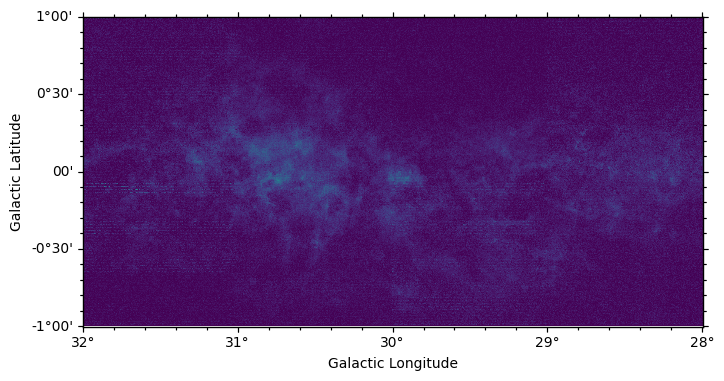

Total mass:  118175115.762787 solar mass


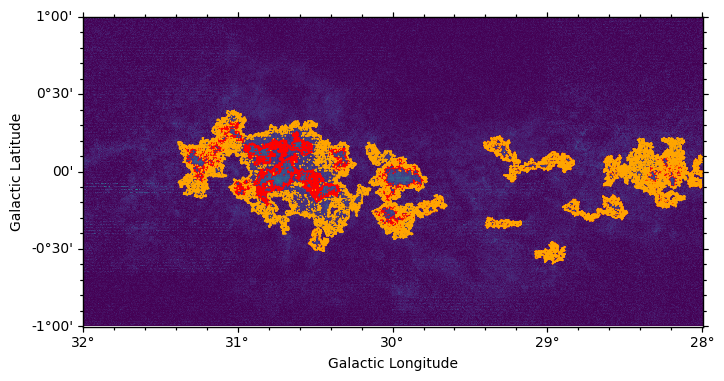

C:\Users\kotor\AppData\Local\Temp\ipykernel_12700\390613153.py:101: MatplotlibDeprecationWarning: The InsetPosition class was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use Axes.inset_axes instead.
  position = InsetPosition(ax, [0.25, 0.35, 0.7, 0.6])
C:\Users\kotor\AppData\Local\Temp\ipykernel_12700\390613153.py:107: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\kotor\AppData\Local\Temp\ipykernel_12700\390613153.py:119: MatplotlibDeprecationWarning: The InsetPosition class was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use Axes.inset_axes instead.
  position = InsetPosition(ax, [0.25, 0.35, 0.7, 0.6])
C:\Users\kotor\AppData\Local\Temp\ipykernel_12700\390613153.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\kotor\AppData\Local\Temp\ipykernel_12700\390613153.py:137: MatplotlibDeprecationWarning: The InsetPosition clas

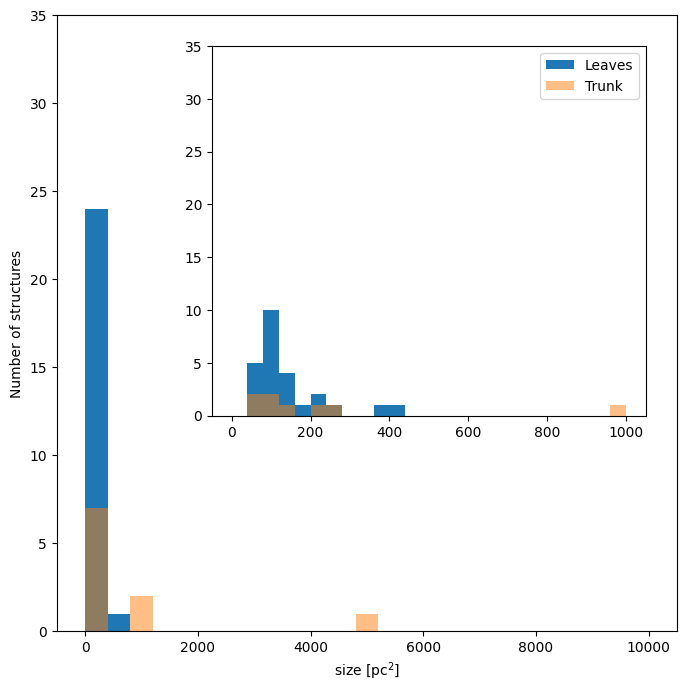

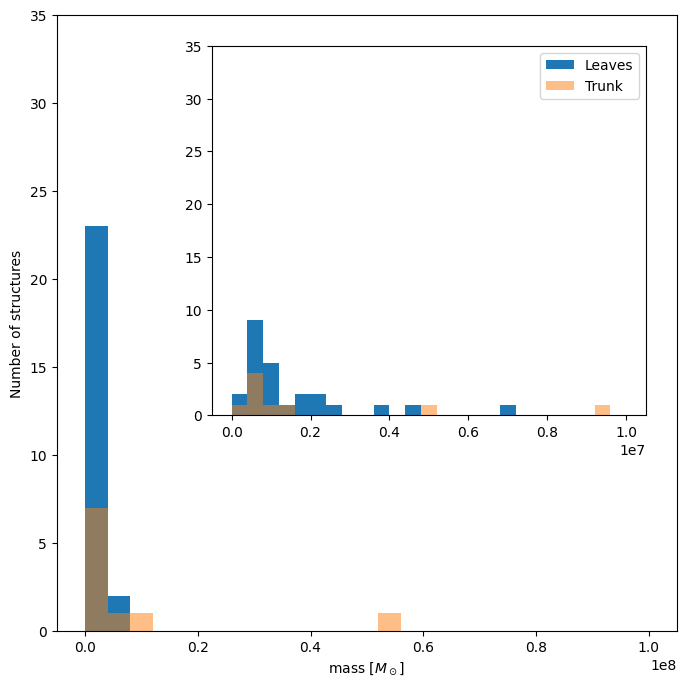

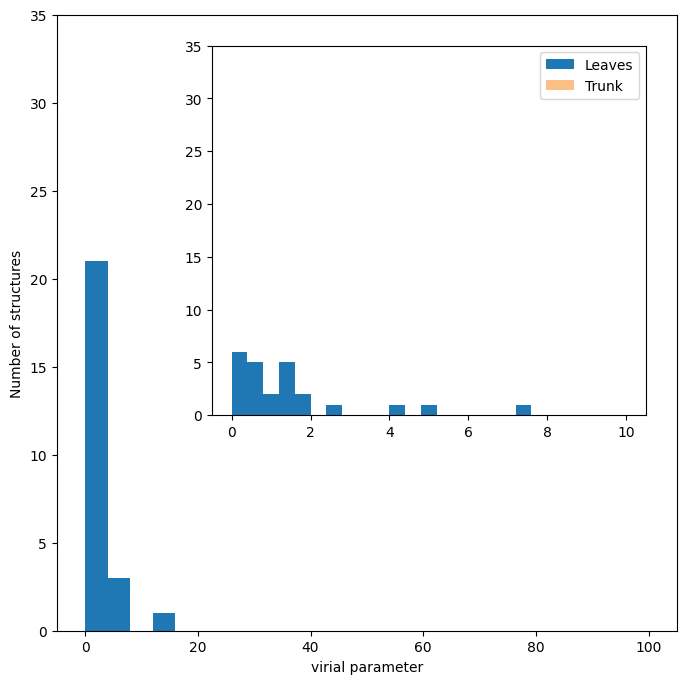

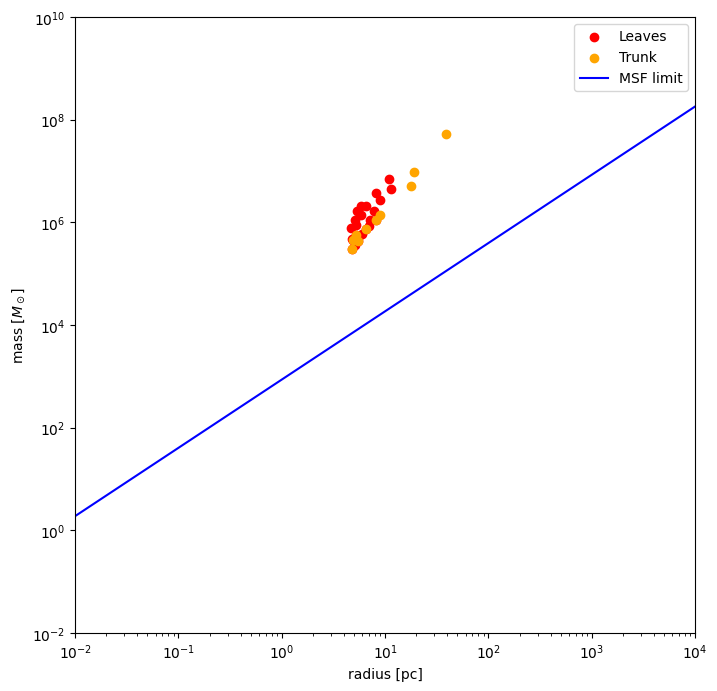

In [10]:
# 13CO

hdu_13CO_1 = fits.open("D:/obsdata/FGN_03100+0000_2x2_13CO_v1.00_cube.fits")[0] # 3D
hdu_13CO_2 = fits.open("D:/obsdata/FGN_02900+0000_2x2_13CO_v1.00_cube.fits")[0] # 3D
w1 = WCS(hdu_13CO_1.header, naxis=2)
w2 = WCS(hdu_13CO_2.header, naxis=2)
new_hdu_13CO, integ_hdu_13CO = integ_concatenate(hdu_13CO_1, hdu_13CO_2)
new_hdu_13CO, mean_hdu_13CO = mean_concatenate(hdu_13CO_1, hdu_13CO_2)
fig = plt.figure(figsize=(8, 8))
f = aplpy.FITSFigure(integ_hdu_13CO, slices=[0], convention='wells', figure=fig)
f.show_colorscale(vmin=1, vmax=500, cmap="viridis", aspect="equal")
plt.show()

total_mass_13CO = calc_mass_13CO(integ_hdu_12CO, mean_hdu_13CO, np.ones(integ_hdu_13CO.data.shape, dtype=bool))
print("Total mass: ", total_mass_13CO, "solar mass")

dendro_min_value = 2 * np.std(integ_hdu_13CO.data)
dendro_min_delta = np.std(integ_hdu_13CO.data)
dendro_min_npix = 1000
d = Dendrogram.compute(integ_hdu_13CO.data, min_value=dendro_min_value, min_delta=dendro_min_delta, min_npix=dendro_min_npix, verbose=False)

fig = plt.figure(figsize=(8, 8))
f = aplpy.FITSFigure(integ_hdu_13CO, slices=[0], convention='wells', figure=fig)
f.show_colorscale(vmin=1, vmax=500, cmap="viridis", aspect="equal")
mask = np.zeros(integ_hdu_13CO.data.shape, dtype=bool)
for s in d.leaves:
    mask = mask | s.get_mask()
mask_hdu = fits.PrimaryHDU(mask.astype('short'), integ_hdu_13CO.header)
f.show_contour(mask_hdu, colors='red', linewidths=0.5)
for s in d.trunk:
    mask = mask | s.get_mask()
mask_hdu = fits.PrimaryHDU(mask.astype('short'), integ_hdu_13CO.header)
f.show_contour(mask_hdu, colors='orange', linewidths=0.5)
plt.show()

index_list, ancestor, size, radius, mass, v_dispersion, vir_param = [], [], [], [], [], [], []
for s in d.leaves:
    stat = PPStatistic(s)
    index_list.append(s.idx)
    ancestor.append(str(s.ancestor.idx))
    area_exact = round(stat.area_exact.value, 0)
    size.append(round(stat.area_exact.value * pix**2, 6))
    radius.append(round(np.sqrt(stat.area_exact.value / np.pi) * pix, 6))
    mask = s.get_mask()
    mass.append(round(calc_mass_13CO(integ_hdu_12CO, mean_hdu_13CO, mask), 6))
    indices = np.where(mask)
    coordinates_list = list(zip(indices[0], indices[1]))
    v_dispersion.append(round(analyze_spectra(coordinates_list, new_hdu_13CO.data) * 0.65, 6))
    vir_param.append(round(1.2e3 * 
                           (np.sqrt(stat.area_exact.value / np.pi) * pix) * 
                           (analyze_spectra(coordinates_list, new_hdu_13CO.data) * 0.65)**2 / 
                           calc_mass_13CO(integ_hdu_12CO, mean_hdu_13CO, mask), 6))
results_leaves = pd.DataFrame({
            'id':index_list, # ID
            'ancestor':ancestor, # (最も)先祖のID
            'size':size, # 構造が実際に使っている面積 (pc^2)
            'radius':radius, # 構造の有効半径 (pc)
            'mass':mass, # 構造の水素原子質量
            'velocity dispersion':v_dispersion, # 速度分散 (km/s)
            'virial parameter':vir_param # ビリアルパラメーター
            })
index_list, ancestor, size, radius, mass, v_dispersion, vir_param = [], [], [], [], [], [], []
for s in d.trunk:
    stat = PPStatistic(s)
    index_list.append(s.idx)
    ancestor.append(str(s.ancestor.idx))
    area_exact = round(stat.area_exact.value, 0)
    size.append(round(stat.area_exact.value * pix**2, 6))
    radius.append(round(np.sqrt(stat.area_exact.value / np.pi) * pix, 6))
    mask = s.get_mask()
    mass.append(round(calc_mass_13CO(integ_hdu_12CO, mean_hdu_13CO, mask), 6))
    indices = np.where(mask)
    coordinates_list = list(zip(indices[0], indices[1]))
    v_dispersion.append(round(analyze_spectra(coordinates_list, new_hdu_13CO.data) * 0.65, 6))
    vir_param.append(round(1.2e3 * 
                           (np.sqrt(stat.area_exact.value / np.pi) * pix) * 
                           (analyze_spectra(coordinates_list, new_hdu_13CO.data) * 0.65)**2 / 
                           3 * calc_mass_13CO(integ_hdu_12CO, mean_hdu_13CO, mask) , 6))
results_trunk = pd.DataFrame({
            'id':index_list, # ID
            'ancestor':ancestor, # (最も)先祖のID
            'size':size, # 構造が実際に使っている面積 (pc^2)
            'radius':radius, # 構造の有効半径 (pc)
            'mass':mass, # 構造の水素原子質量
            'velocity dispersion':v_dispersion, # 速度分散 (km/s)
            'virial parameter':vir_param # ビリアルパラメーター
            })
results_leaves.to_csv("C:/Users/kotor/StarGen/datasets/obsdata/W43/13CO_leaves.csv")
results_trunk.to_csv("C:/Users/kotor/StarGen/datasets/obsdata/W43/13CO_trunk.csv")

fig, ax = plt.subplots(figsize=(8, 8))
bins = 25
range = (0, 10000)
range2 = (0, 1000)
ax.hist(results_leaves["size"], bins=bins, range=range, label='Leaves')
ax.hist(results_trunk["size"], bins=bins, range=range, alpha=0.5, label='Trunk')
ax.set_yticks(np.arange(0, 40, 5))
ax.set_xlabel('size [pc$^2$]')
ax.set_ylabel('Number of structures')
ax2 = plt.axes([0, 0, 1, 1])
position = InsetPosition(ax, [0.25, 0.35, 0.7, 0.6])
ax2.set_axes_locator(position)
ax2.hist(results_leaves["size"], bins=bins, range=range2, label='Leaves')
ax2.hist(results_trunk["size"], bins=bins, range=range2, alpha=0.5, label='Trunk')
ax2.set_yticks(np.arange(0, 40, 5))
ax2.legend()
fig.show()

fig, ax = plt.subplots(figsize=(8, 8))
bins = 25
range = (0, 1e8)
range2 = (0, 1e7)
ax.hist(results_leaves["mass"], bins=bins, range=range, label='Leaves')
ax.hist(results_trunk["mass"], bins=bins, range=range, alpha=0.5, label='Trunk')
ax.set_yticks(np.arange(0, 40, 5))
ax.set_xlabel('mass [$M_\odot$]')
ax.set_ylabel('Number of structures')
ax2 = plt.axes([0, 0, 1, 1])
position = InsetPosition(ax, [0.25, 0.35, 0.7, 0.6])
ax2.set_axes_locator(position)
ax2.hist(results_leaves["mass"], bins=bins, range=range2, label='Leaves')
ax2.hist(results_trunk["mass"], bins=bins, range=range2, alpha=0.5, label='Trunk')
ax2.set_yticks(np.arange(0, 40, 5))
ax2.legend()
fig.show()

fig, ax = plt.subplots(figsize=(8, 8))
bins = 25
range = (0, 100)
range2 = (0, 10)
ax.hist(results_leaves["virial parameter"], bins=bins, range=range, label='Leaves')
ax.hist(results_trunk["virial parameter"], bins=bins, range=range, alpha=0.5, label='Trunk')
ax.set_yticks(np.arange(0, 40, 5))
ax.set_xlabel('virial parameter')
ax.set_ylabel('Number of structures')
ax2 = plt.axes([0, 0, 1, 1])
position = InsetPosition(ax, [0.25, 0.35, 0.7, 0.6])
ax2.set_axes_locator(position)
ax2.hist(results_leaves["virial parameter"], bins=bins, range=range2, label='Leaves')
ax2.hist(results_trunk["virial parameter"], bins=bins, range=range2, alpha=0.5, label='Trunk')
ax2.set_yticks(np.arange(0, 40, 5))
ax2.legend()
fig.show()

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(results_leaves["radius"], results_leaves["mass"], label='Leaves', color='red')
ax.scatter(results_trunk["radius"], results_trunk["mass"], label='Trunk', color='orange')
def MSF_limit(r):
    return 870 * r ** 1.33
r = np.linspace(0.01, 10e3, 100)
m = MSF_limit(r)
ax.plot(r, m, label='MSF limit', color='blue')
ax.set_xlim(0.01, 10e3)
ax.set_ylim(0.01, 10e9)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('radius [pc]')
ax.set_ylabel('mass [$M_\odot$]')
ax.legend()
fig.show()

<>:121: SyntaxWarning: invalid escape sequence '\o'
<>:121: SyntaxWarning: invalid escape sequence '\o'
C:\Users\kotor\AppData\Local\Temp\ipykernel_12648\2720085745.py:121: SyntaxWarning: invalid escape sequence '\o'
  ax.set_xlabel('mass [$M_\odot$]')


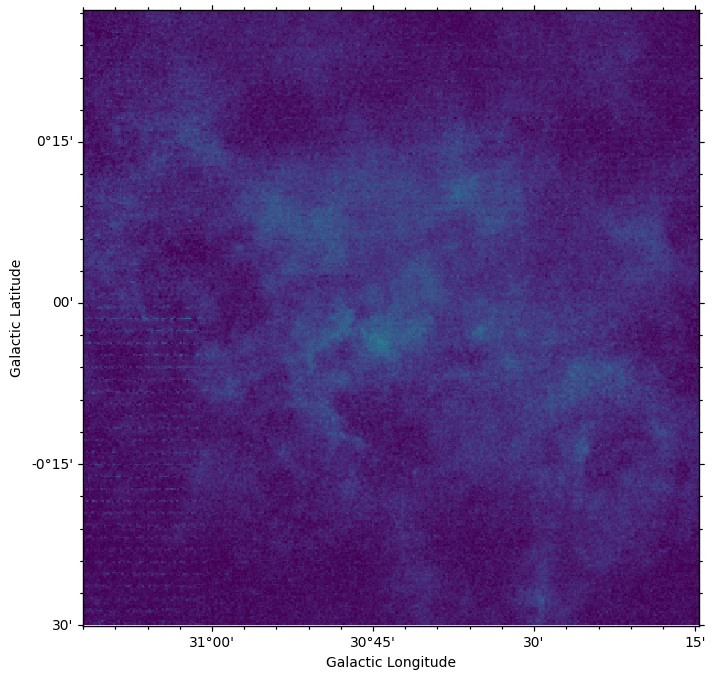

Total mass:  87531866.9144451 solar mass


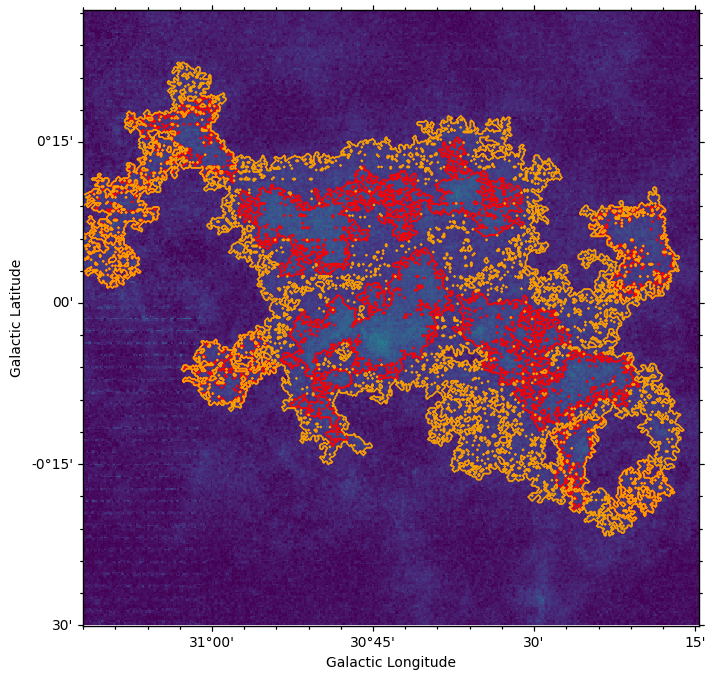

C:\Users\kotor\AppData\Local\Temp\ipykernel_12648\2720085745.py:106: MatplotlibDeprecationWarning: The InsetPosition class was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use Axes.inset_axes instead.
  position = InsetPosition(ax, [0.25, 0.35, 0.7, 0.6])
C:\Users\kotor\AppData\Local\Temp\ipykernel_12648\2720085745.py:112: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\kotor\AppData\Local\Temp\ipykernel_12648\2720085745.py:124: MatplotlibDeprecationWarning: The InsetPosition class was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use Axes.inset_axes instead.
  position = InsetPosition(ax, [0.25, 0.35, 0.7, 0.6])
C:\Users\kotor\AppData\Local\Temp\ipykernel_12648\2720085745.py:130: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\kotor\AppData\Local\Temp\ipykernel_12648\2720085745.py:142: MatplotlibDeprecationWarning: The InsetPosition

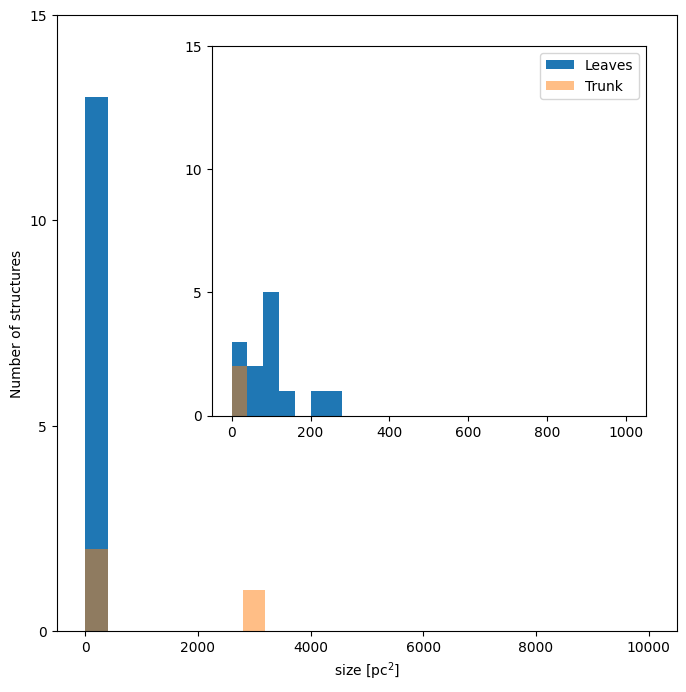

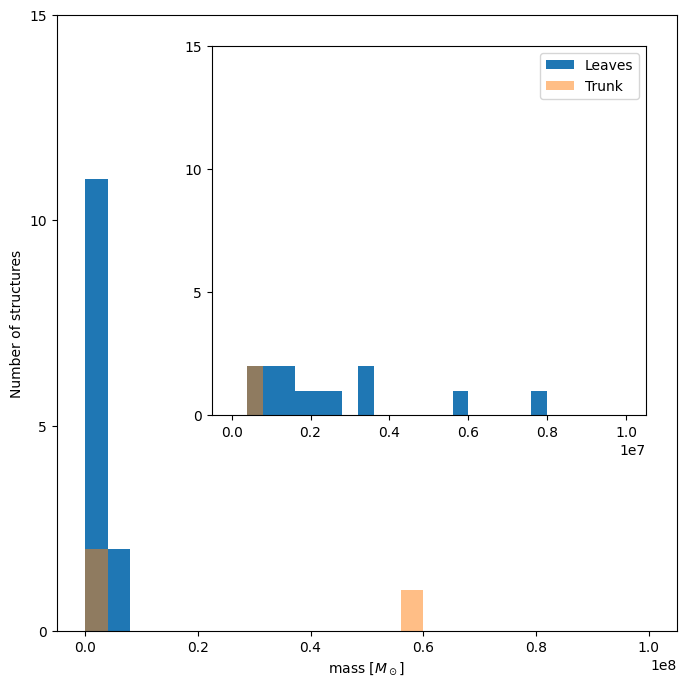

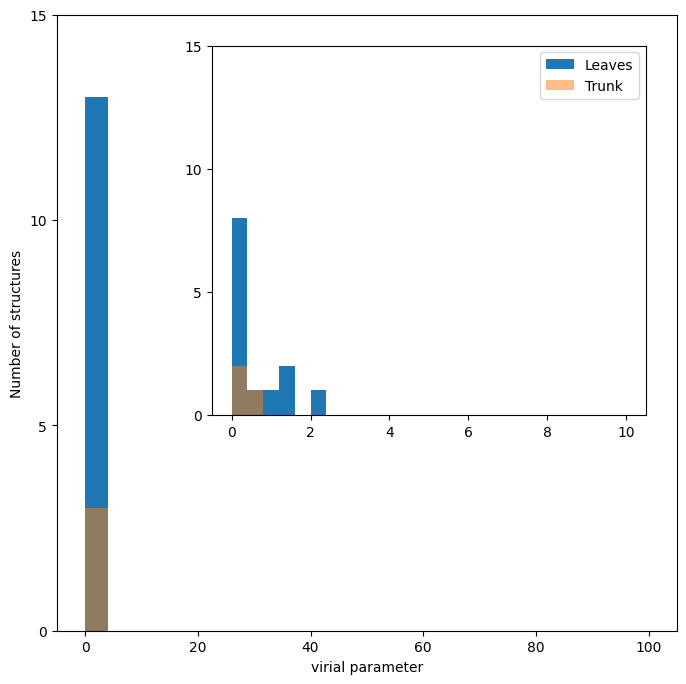

In [ ]:
# 13CO (100 * 100 pc^2)

degree = (100 / pix) * (2 / 848)
x_start = 31.2
x_end = x_start - degree
y_start = -0.5
y_end = y_start + degree

sliced_hdu_12CO = xy_cut(hdu_12CO_1, x_start, x_end, y_start, y_end)
sliced_hdu_13CO = xy_cut(hdu_13CO_1, x_start, x_end, y_start, y_end)
integ_hdu_12CO = make_new_hdu_integ(sliced_hdu_12CO)
integ_hdu_13CO = make_new_hdu_integ(sliced_hdu_13CO)
mean_hdu_13CO = make_new_hdu_mean(sliced_hdu_13CO)
fig = plt.figure(figsize=(8, 8))
f = aplpy.FITSFigure(integ_hdu_13CO, slices=[0], convention='wells', figure=fig)
f.show_colorscale(vmin=1, vmax=500, cmap="viridis", aspect="equal")
plt.show()

total_mass_13CO = calc_mass_13CO(integ_hdu_12CO, mean_hdu_13CO, np.ones(integ_hdu_13CO.data.shape, dtype=bool))
print("Total mass: ", total_mass_13CO, "solar mass")

dendro_min_value = 2 * np.std(integ_hdu_13CO.data)
dendro_min_delta = np.std(integ_hdu_13CO.data)
dendro_min_npix = 500
d = Dendrogram.compute(integ_hdu_13CO.data, min_value=dendro_min_value, min_delta=dendro_min_delta, min_npix=dendro_min_npix, verbose=False)

fig = plt.figure(figsize=(8, 8))
f = aplpy.FITSFigure(integ_hdu_13CO, slices=[0], convention='wells', figure=fig)
f.show_colorscale(vmin=1, vmax=500, cmap="viridis", aspect="equal")
mask = np.zeros(integ_hdu_13CO.data.shape, dtype=bool)
for s in d.leaves:
    mask = mask | s.get_mask()
mask_hdu = fits.PrimaryHDU(mask.astype('short'), integ_hdu_13CO.header)
f.show_contour(mask_hdu, colors='red', linewidths=0.5)
for s in d.trunk:
    mask = mask | s.get_mask()
mask_hdu = fits.PrimaryHDU(mask.astype('short'), integ_hdu_13CO.header)
f.show_contour(mask_hdu, colors='orange', linewidths=0.5)
plt.show()

index_list, ancestor, size, radius, mass, v_dispersion, vir_param = [], [], [], [], [], [], []
for s in d.leaves:
    stat = PPStatistic(s)
    index_list.append(s.idx)
    ancestor.append(str(s.ancestor.idx))
    area_exact = round(stat.area_exact.value, 0)
    size.append(round(stat.area_exact.value * pix**2, 6))
    radius.append(round(np.sqrt(stat.area_exact.value / np.pi) * pix, 6))
    mask = s.get_mask()
    mass.append(round(calc_mass_13CO(integ_hdu_12CO, mean_hdu_13CO, mask), 6))
    indices = np.where(mask)
    coordinates_list = list(zip(indices[0], indices[1]))
    v_dispersion.append(round(analyze_spectra(coordinates_list, new_hdu_13CO.data) * 0.65, 6))
    vir_param.append(round(1.2e3 * 
                           (np.sqrt(stat.area_exact.value / np.pi) * pix) * 
                           (analyze_spectra(coordinates_list, new_hdu_12CO.data) * 0.65)**2 / 
                           calc_mass_13CO(integ_hdu_12CO, mean_hdu_13CO, mask), 6))
results_leaves = pd.DataFrame({
            'id':index_list, # ID
            'ancestor':ancestor, # (最も)先祖のID
            'size':size, # 構造が実際に使っている面積 (pc^2)
            'radius':radius, # 構造の有効半径 (pc)
            'mass':mass, # 構造の水素原子質量
            'velocity dispersion':v_dispersion, # 速度分散 (km/s)
            'virial parameter':vir_param # ビリアルパラメーター
            })
index_list, ancestor, size, radius, mass, v_dispersion, vir_param = [], [], [], [], [], [], []
for s in d.trunk:
    stat = PPStatistic(s)
    index_list.append(s.idx)
    ancestor.append(str(s.ancestor.idx))
    area_exact = round(stat.area_exact.value, 0)
    size.append(round(stat.area_exact.value * pix**2, 6))
    radius.append(round(np.sqrt(stat.area_exact.value / np.pi) * pix, 6))
    mask = s.get_mask()
    mass.append(round(calc_mass_13CO(integ_hdu_12CO, mean_hdu_13CO, mask), 6))
    indices = np.where(mask)
    coordinates_list = list(zip(indices[0], indices[1]))
    v_dispersion.append(round(analyze_spectra(coordinates_list, new_hdu_13CO.data) * 0.65, 6))
    vir_param.append(round(1.2e3 * 
                           (np.sqrt(stat.area_exact.value / np.pi) * pix) * 
                           (analyze_spectra(coordinates_list, new_hdu_12CO.data) * 0.65)**2 / 
                           calc_mass_13CO(integ_hdu_12CO, mean_hdu_13CO, mask), 6))
results_trunk = pd.DataFrame({
            'id':index_list, # ID
            'ancestor':ancestor, # (最も)先祖のID
            'size':size, # 構造が実際に使っている面積 (pc^2)
            'radius':radius, # 構造の有効半径 (pc)
            'mass':mass, # 構造の水素原子質量
            'velocity dispersion':v_dispersion, # 速度分散 (km/s)
            'virial parameter':vir_param # ビリアルパラメーター
            })
results_leaves.to_csv("C:/Users/kotor/StarGen/datasets/obsdata/W43/13CO_100x100_leaves.csv")
results_trunk.to_csv("C:/Users/kotor/StarGen/datasets/obsdata/W43/13CO_100x100_trunk.csv")

fig, ax = plt.subplots(figsize=(8, 8))
bins = 25
range = (0, 10000)
range2 = (0, 1000)
ax.hist(results_leaves["size"], bins=bins, range=range, label='Leaves')
ax.hist(results_trunk["size"], bins=bins, range=range, alpha=0.5, label='Trunk')
ax.set_yticks(np.arange(0, 20, 5))
ax.set_xlabel('size [pc$^2$]')
ax.set_ylabel('Number of structures')
ax2 = plt.axes([0, 0, 1, 1])
position = InsetPosition(ax, [0.25, 0.35, 0.7, 0.6])
ax2.set_axes_locator(position)
ax2.hist(results_leaves["size"], bins=bins, range=range2, label='Leaves')
ax2.hist(results_trunk["size"], bins=bins, range=range2, alpha=0.5, label='Trunk')
ax2.set_yticks(np.arange(0, 20, 5))
ax2.legend()
fig.show()

fig, ax = plt.subplots(figsize=(8, 8))
bins = 25
range = (0, 1e8)
range2 = (0, 1e7)
ax.hist(results_leaves["mass"], bins=bins, range=range, label='Leaves')
ax.hist(results_trunk["mass"], bins=bins, range=range, alpha=0.5, label='Trunk')
ax.set_yticks(np.arange(0, 20, 5))
ax.set_xlabel('mass [$M_\odot$]')
ax.set_ylabel('Number of structures')
ax2 = plt.axes([0, 0, 1, 1])
position = InsetPosition(ax, [0.25, 0.35, 0.7, 0.6])
ax2.set_axes_locator(position)
ax2.hist(results_leaves["mass"], bins=bins, range=range2, label='Leaves')
ax2.hist(results_trunk["mass"], bins=bins, range=range2, alpha=0.5, label='Trunk')
ax2.set_yticks(np.arange(0, 20, 5))
ax2.legend()
fig.show()

fig, ax = plt.subplots(figsize=(8, 8))
bins = 25
range = (0, 100)
range2 = (0, 10)
ax.hist(results_leaves["virial parameter"], bins=bins, range=range, label='Leaves')
ax.hist(results_trunk["virial parameter"], bins=bins, range=range, alpha=0.5, label='Trunk')
ax.set_yticks(np.arange(0, 20, 5))
ax.set_xlabel('virial parameter')
ax.set_ylabel('Number of structures')
ax2 = plt.axes([0, 0, 1, 1])
position = InsetPosition(ax, [0.25, 0.35, 0.7, 0.6])
ax2.set_axes_locator(position)
ax2.hist(results_leaves["virial parameter"], bins=bins, range=range2, label='Leaves')
ax2.hist(results_trunk["virial parameter"], bins=bins, range=range2, alpha=0.5, label='Trunk')
ax2.set_yticks(np.arange(0, 20, 5))
ax2.legend()
fig.show()